<center>
<img src="img/logo.jpeg" width=1000 height=800 />
    </center>

In [1]:
import verticapy as vp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from verticapy.utilities import *
from verticapy.learn.ensemble import RandomForestClassifier, XGBoostClassifier
from verticapy.learn.model_selection import grid_search_cv
import seaborn as sns
from verticapy.learn.metrics import multilabel_confusion_matrix, f1_score
from verticapy.learn.delphi import AutoML
from sklearn.metrics import cohen_kappa_score

create_verticapy_schema()
%matplotlib inline

In [2]:
# Create new connection with database
vp.new_connection({"host": "localhost",
                   "port": "5433",
                   "database": "VMart",
                   "password": "",
                   "user": "dbadmin"},
                  name="Vertica_New_Connection")
# Connect with the database
vp.connect("Vertica_New_Connection")

In [3]:
# Drop any schema with insurance_data name
vp.drop("insurance", method="schema")
# Create new schema with name insurrance_data
vp.create_schema("insurance", True)

True

## Read dataset

Read and create a Virtual DataFrame of the dataset

The table "insurance"."insurance" has been successfully created.


,123ageInt,AbcsexVarchar(20),"123bmiNumeric(8,4)",123childrenInt,010smokerBoolean,AbcregionVarchar(20),123chargesFloat
1,18,female,20.79,0,❌,southeast,1607.5101
2,18,female,21.66,0,✅,northeast,14283.4594
3,18,female,24.09,1,❌,southeast,2201.0971
4,18,female,25.08,0,❌,northeast,2196.4732
5,18,female,26.315,0,❌,northeast,2198.18985
6,18,female,26.73,0,❌,southeast,1615.7667
7,18,female,27.28,3,✅,southeast,18223.4512
8,18,female,28.215,0,❌,northeast,2200.83085
9,18,female,29.165,0,❌,northeast,7323.734819
10,18,female,30.115,0,❌,northeast,2203.47185

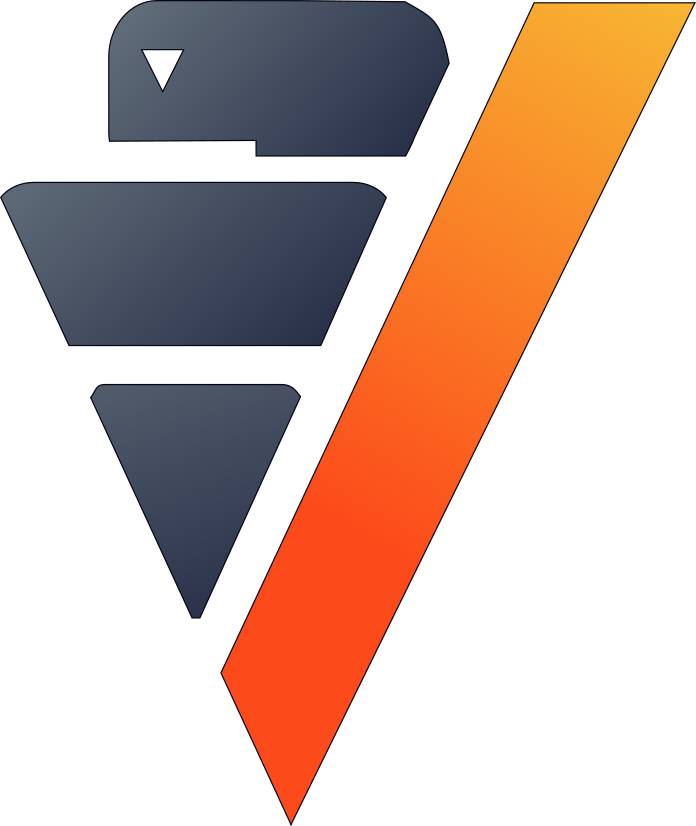

In [4]:
# Read the dataset
insurance_data = vp.read_csv("data/insurance.csv", schema="insurance")
display(insurance_data)

## Data Exploration

First step is to explore the data, as we see the data contains 1338 record with 7 features:
* age: age of the client
* sex: insurance contractor gender: female, male
* bmi: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height,objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9
* children: Number of children covered by health insurance / Number of dependents
* smoker: whether the client is a smoker or not
* region: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.
* charges: Individual medical costs billed by health insurance

,count,percent
"""age""",1338.0,100.0
"""sex""",1338.0,100.0
"""bmi""",1338.0,100.0
"""children""",1338.0,100.0
"""smoker""",1338.0,100.0
"""region""",1338.0,100.0
"""charges""",1338.0,100.0

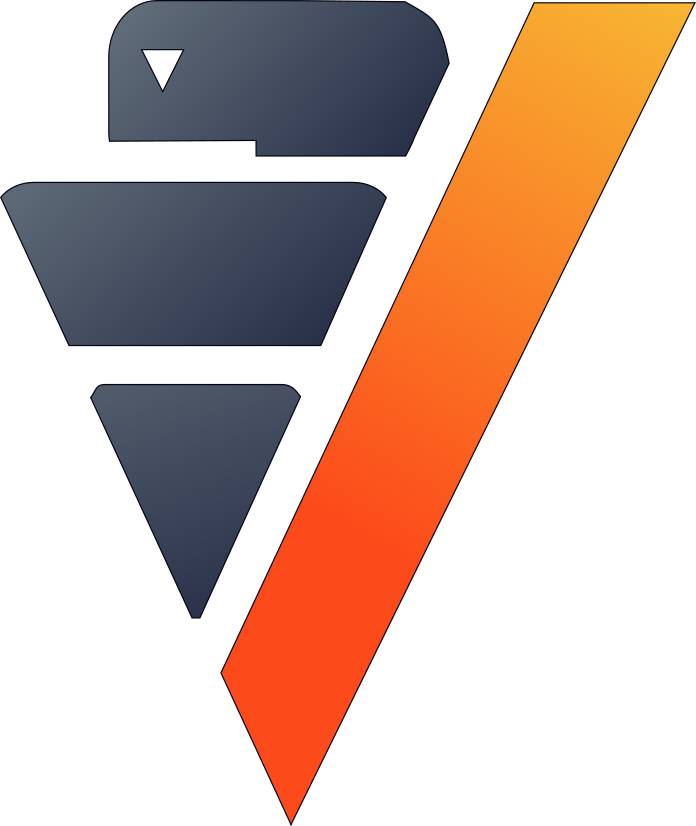

In [5]:
# count the number of non-null entries per column
insurance_data.count_percent()

,approx_unique
"""sex""",2.0
"""smoker""",2.0
"""region""",4.0

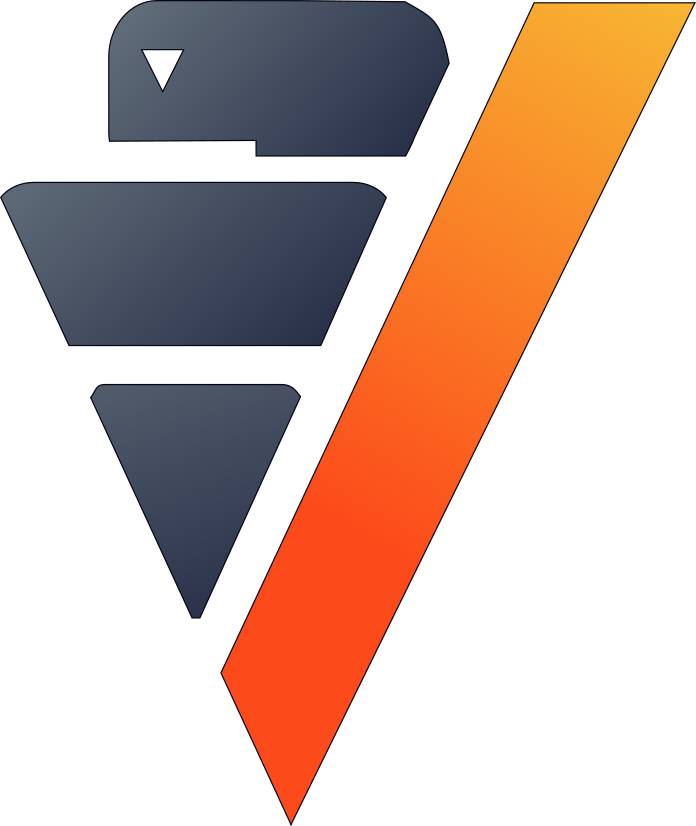

In [6]:
# Check if there are some corrupted values in categorical columns
insurance_data.nunique(columns=["sex",
                                "smoker",
                                "region"])

There is no null value or corrupted value in categorical features 

,count,mean,std,min,approx_25%,approx_50%,approx_75%,max
"""age""",1338,39.2070254110613,14.0499603792161,18.0,27.0,39.0,51.0,64.0
"""bmi""",1338,30.6633968609865,6.09818691167901,15.96,26.29625,30.4,34.69375,53.13
"""children""",1338,1.0949177877429,1.20549273978192,0.0,0.0,1.0,2.0,5.0
"""charges""",1338,13270.4222651412,12110.011236694,1121.8739,4740.28715,9379.1847,16639.912515,63770.42801

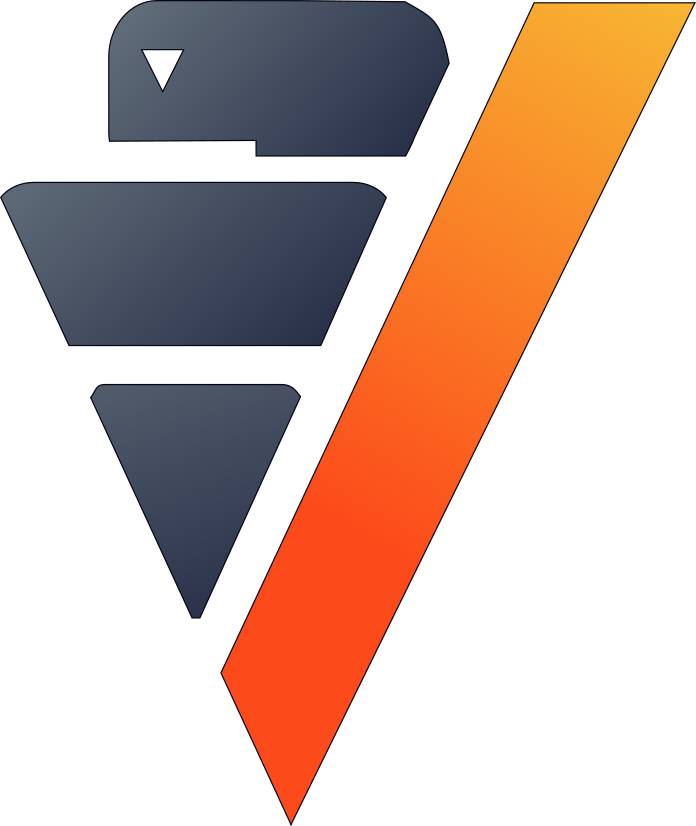

In [7]:
# display description of numerical features
insurance_data[["age", "bmi", "children", "charges"]
               ].describe(method="numerical")

,dtype,count,top,top_percent
"""sex""",varchar(20),1338,male,50.523
"""smoker""",boolean,1338,❌,79.522
"""region""",varchar(20),1338,southeast,27.205

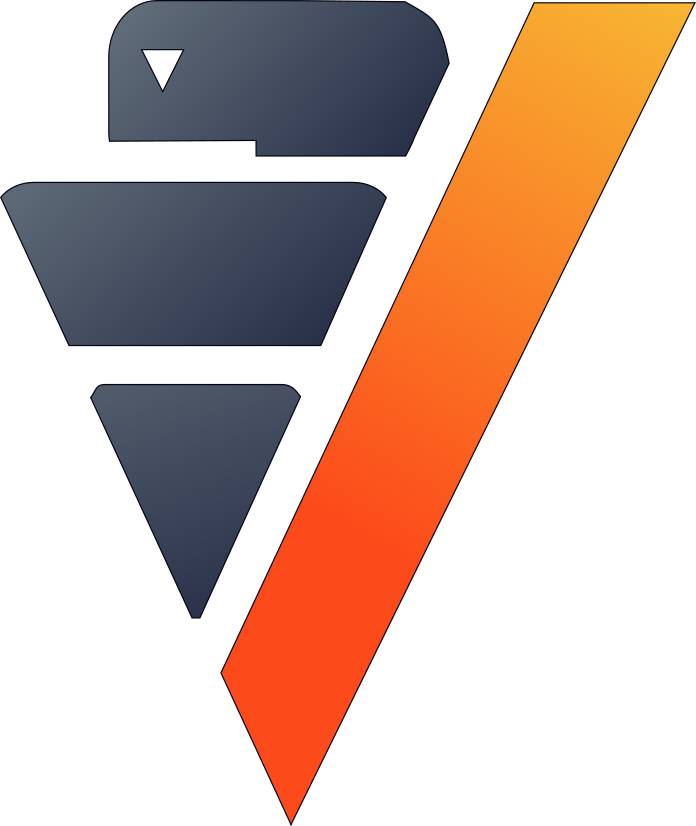

In [8]:
# display description of categorical features
insurance_data[["sex", "smoker", "region"]].describe(method="categorical")

In the following part we are going to perform univariate and multivariate analysis of different characteristics of the samples like: gender, ages, number of children, smoker or not,.... 

## Univariate and multivariate analysis
### Charges

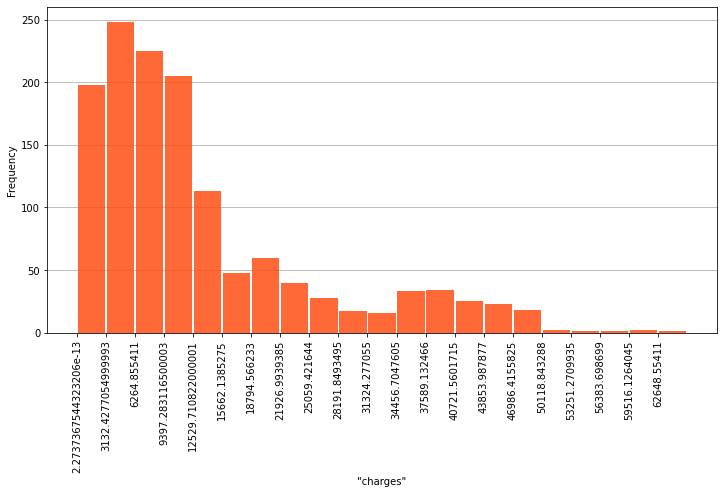

In [9]:
ax = insurance_data["charges"].hist(method="count",
                                    nbins=20,
                                    h=5,
                                    color='#FE5016')

In [10]:
# Boxplot of charges
insurance_data.hchart(x="charges",
                      kind="boxplot",
                      height=400,
                      width=500)

We notice the majority of insurance charges are lower than 15K 

### Gender

In [11]:
# Plot the number of different genders
insurance_data.hchart(x="sex",
                      kind="pie",
                      height=300,
                      width=500)

In [12]:
# Plot the average charges for different gender
insurance_data.hchart(x="sex",
                      y="AVG(charges) AS Average_charges",
                      kind="bar",
                      height=250,
                      width=400)

The genders have equal representation within the dataset (almost 50%). Moreover,  We can see that the average of charges withing females is lower that the male one.
- We can assume that the gender has slight effect on the insurance charges.

### Smoker

We will add a column for visualization purposes to display the tags `smoker` and `none smoker` in our charts 

,123ageInt,AbcsexVarchar(20),"123bmiNumeric(8,4)",123childrenInt,010smokerBoolean,AbcregionVarchar(20),123chargesFloat,Abcsmoker_statusVarchar(11)
1,18,female,20.79,0,❌,southeast,1607.5101,none smoker
2,18,female,21.66,0,✅,northeast,14283.4594,smoker
3,18,female,24.09,1,❌,southeast,2201.0971,none smoker
4,18,female,25.08,0,❌,northeast,2196.4732,none smoker
5,18,female,26.315,0,❌,northeast,2198.18985,none smoker
6,18,female,26.73,0,❌,southeast,1615.7667,none smoker
7,18,female,27.28,3,✅,southeast,18223.4512,smoker
8,18,female,28.215,0,❌,northeast,2200.83085,none smoker
9,18,female,29.165,0,❌,northeast,7323.734819,none smoker
10,18,female,30.115,0,❌,northeast,2203.47185,none smoker

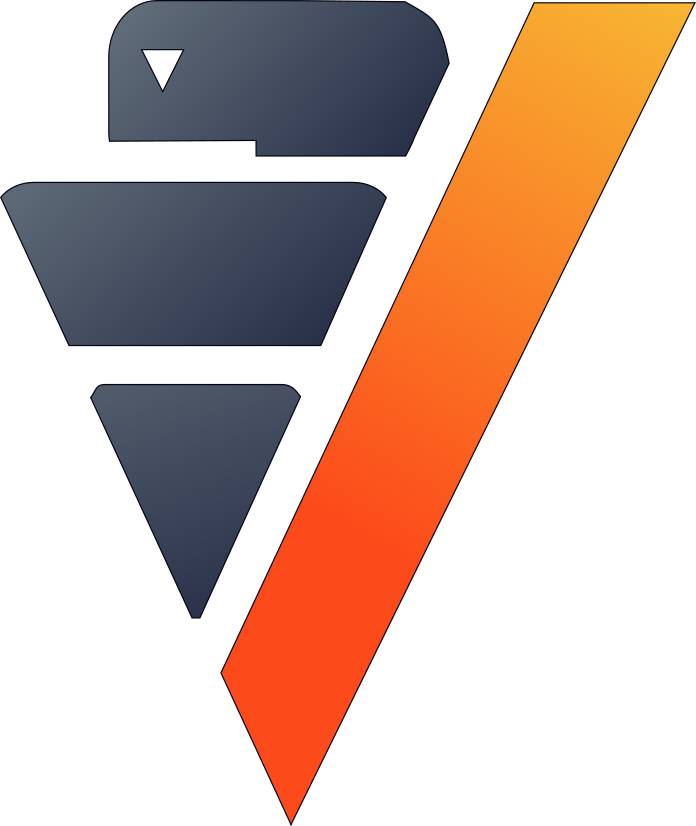

In [13]:
# Add column smoker_status for visualization purposes
insurance_data.case_when("smoker_status",
                         insurance_data["smoker"] == 1, "smoker",
                         "none smoker")

In [14]:
# Plot the count of somker and none smokers
insurance_data.hchart(x="smoker_status",
                      kind="pie",
                      height=300,
                      width=500)

In [15]:
# Plot the average charges for smoker and
# none smokers
insurance_data.hchart(x="smoker_status",
                      y="AVG(charges) AS Average_charges",
                      kind="bar",
                      height=300,
                      width=400)

* The `smoker` individuals represent __20%__ of the samples and `none smoker` represent __80%__.
* It is clear that the average charges of smoker person are almost __4 time__ higher by __32K__ than none smoker person with average of __8.5K__. From this observation we can say that `smoking status` of a person is highly affecting the insurance charges.

In [16]:
# Distribution of the smoker withing gender
insurance_data.hchart(x="smoker_status",
                      y="sex",
                      z="COUNT(sex)",
                      kind="bar",
                      height=250,
                      width=900)

In [17]:
# The average charges for smoker withing genders
insurance_data.hchart(x="smoker_status",
                      y="sex",
                      z="ROUND(AVG(charges)) AS Average_charges",
                      kind="bar",
                      height=250,
                      width=900)

We observe that there is more smoking women than men in the samples, however, the average charges of smoking men is higher than the women's one. We can say that our assumption about the relation between gender and charges is present in this case also.

### Number of children 

In [18]:
# Plot the distribution of number of dependent
# children
insurance_data.hchart(x="children",
                      z="COUNT(children) AS nbr_children",
                      y="children",
                      kind="bar",
                      height=300,
                      width=450)

In [19]:
# Boxplot for charges with respect to number
# of children
insurance_data.hchart(x="charges",
                      y="children",
                      kind="boxplot",
                      height=300,
                      width=450)

In [20]:
# Add a new feature children Status
# insurance_data.drop(columns=['children_status'])
insurance_data.case_when("children_status",
                         insurance_data["children"] == 0, "no children",
                         "has children")
# Plot number of people with or without childre w.r.t gender
insurance_data.hchart(x="children_status",
                      y="sex",
                      z="COUNT(sex)",
                      kind="bar",
                      height=250,
                      width=900)

In [21]:
# Plot the average of insurance charges of different gender with respect to number of children
insurance_data.hchart(x="Children",
                      y="sex",
                      z="ROUND(AVG(charges)) AS Average_charges",
                      kind="bar",
                      height=400,
                      width=900)

We see that the parents with 5 children have the lowest insurance charges, and the ones that have 2,3, or 4 have higher charges. which is not normal, because more people normally means more insurance charges. We can explain this results by the proportion of the people that have 5 kids where they represent __1.3%__ of the samples.

### Age 

In [22]:
# Distribution of the peoples's age
insurance_data.hchart(x="age",
                      kind="bar",
                      h=2,
                      height=400,
                      width=900)

The young adults of 18 and 19 years old are significantly frequent comparing to all other ages, they are more than double frequent than every age. 

In [23]:
# Boxplot for charges with respect to age
insurance_data.hchart(x="charges",
                      y="age",
                      kind="boxplot",
                      height=500,
                      width=1000)

It is clear that the trend of the average charges is increasing with respects to the age.

In [24]:
# Distribution of the peoples's age vs bmi
insurance_data.hchart(x="age",
                      y='AVG(bmi) AS Average_BMI',
                      kind="bar",
                      h=10,
                      aggregate=True,
                      height=250,
                      width=900)

This graph explain one reason of high insurance charges of older people, which is __BMI__. Older people tend to have more weight than the standards.

### BMI

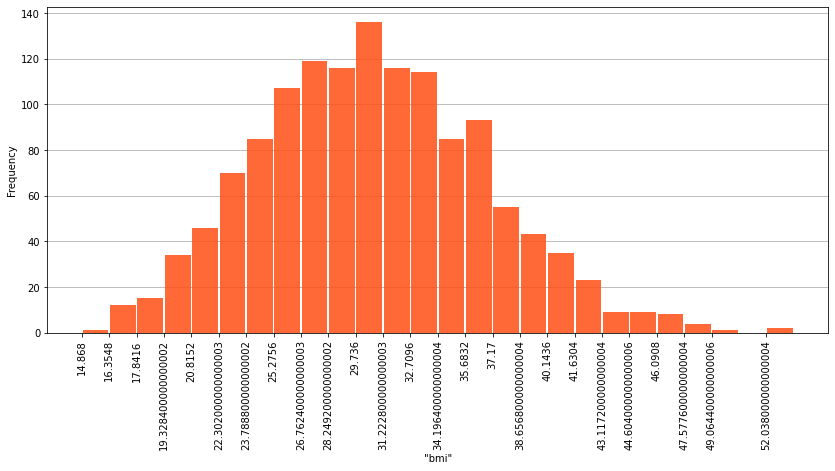

In [25]:
# Distribution of bmi
ax = insurance_data["bmi"].hist(method="count",
                                nbins=25,
                                h=5,
                                color='#FE5016')

We categorize the BMI to 4 category based on its value:

|BMI|	Weight Status|
|---|----------------|
|Below 18.5	|Underweight|
|18.5—24.9	|Healthy|
|25.0—29.9	|Overweight|
|30.0 and Above	|Obese|

We can notice that the persons with `bmi` higher than 30 have higher charges, as mentioned above, those people are categorized as __overweight__ individuals.
We will add a column `ws` that referring to weight status of each sample.

,123ageInt,AbcsexVarchar(20),"123bmiNumeric(8,4)",123childrenInt,010smokerBoolean,AbcregionVarchar(20),123chargesFloat,Abcsmoker_statusVarchar(11),Abcchildren_statusVarchar(12),AbcwsVarchar(11)
1,18,female,20.79,0,❌,southeast,1607.5101,none smoker,no children,Healthy
2,18,female,21.66,0,✅,northeast,14283.4594,smoker,no children,Healthy
3,18,female,24.09,1,❌,southeast,2201.0971,none smoker,has children,Healthy
4,18,female,25.08,0,❌,northeast,2196.4732,none smoker,no children,Overweight
5,18,female,26.315,0,❌,northeast,2198.18985,none smoker,no children,Overweight
6,18,female,26.73,0,❌,southeast,1615.7667,none smoker,no children,Overweight
7,18,female,27.28,3,✅,southeast,18223.4512,smoker,has children,Overweight
8,18,female,28.215,0,❌,northeast,2200.83085,none smoker,no children,Overweight
9,18,female,29.165,0,❌,northeast,7323.734819,none smoker,no children,Overweight
10,18,female,30.115,0,❌,northeast,2203.47185,none smoker,no children,Obese

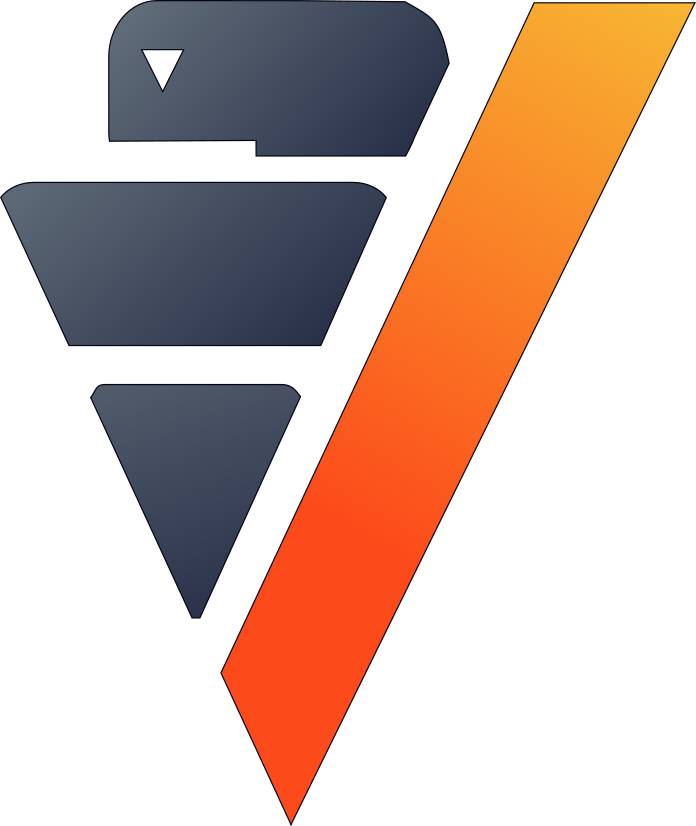

In [26]:
# Add a new feature Weight Status
insurance_data.case_when("ws",
                         insurance_data["bmi"] < 18.5, "Underweight",
                         insurance_data["bmi"] < 25, "Healthy",
                         insurance_data["bmi"] < 30, "Overweight",
                         "Obese")

In [27]:
# Add a new feature for visualization purpose
# insurance_data.drop(columns=['charges_cat'])
insurance_data.case_when("charges_cat",
                         insurance_data["charges"] <=32000 , "lower than 32k",
                         "above 32k")
# Scatter plot od the bmi vs charges
insurance_data.hchart(x="bmi",
                      y="charges",
                      c="charges_cat",
                      kind="scatter",
                      height=400,
                      width=900)

We can see that the majority of the charges above __32k__ where charged on __obese__ people.

In [28]:
# distribution of the weight status 
insurance_data.hchart(x="ws",
                      y="ws",
                      z="COUNT(ws) AS Frequency",
                      kind="bar",
                      height=300,
                      width=800)

In [29]:
# Boxplot of charges w.r.t weight status
insurance_data.hchart(x="charges",
                      y="ws",
                      kind="boxplot",
                      height=300,
                      width=450)

In [30]:
# Average charges w.r.t to weights status
insurance_data.hchart(x="ws",
                      y="ws",
                      z="ROUND(AVG(charges)) As Avg_charges",
                      kind="bar",
                      height=300,
                      width=450)

* We can see that the persons categorized as `Obese` and `Overweight` representing __81.6%__ of the population
* Underweight people have the lowest charges compare to all the other categorize, and as expected the obese person are more likely to have health issues.

In [31]:
# Display the average score of bmi for every gender
insurance_data.hchart(x="sex",
                      y="sex",
                      z="ROUND(AVG(bmi),2) AS Avg_BMI",
                      kind="bar",
                      height=250,
                      width=900)

In [32]:
# Display the distribution of bmi category with respect to every gender
insurance_data.hchart(x="ws",
                      y="sex",
                      z="COUNT(ws)",
                      kind="bar",
                      height=300,
                      width=900)

In [33]:
# distribution of average charges w.r.t weight status and gender
insurance_data.hchart(x="ws",
                      y="sex",
                      z="ROUND(AVG(charges)) AS Avg_charges",
                      kind="bar",
                      height=300,
                      width=900)

We can observe __obese__ people have higher charges regardless of their gender.

### Region

In [34]:
# Plot the count population in every region
insurance_data.hchart(x="region",
                      kind="pie",
                      height=300,
                      width=800)

The distribution of the population on the four regions is uniform (24%-27%)

In [35]:
# Display the average score of bmi for every region
insurance_data.hchart(x="region",
                      y="AVG(bmi) AS Average_BMI",
                      kind="bar",
                      height=250,
                      width=900)

In [36]:
# Display the average charges by the region
insurance_data.hchart(x="region",
                      y="AVG(charges) AS Average_Charges",
                      kind="bar",
                      height=250,
                      width=900)

We see that __southeast__ has the higher __BMI__ average and also has the higher average of charges.

In [37]:
# Average charges of each gender by the region
insurance_data.hchart(x="sex",
                      y="region",
                      z="ROUND(AVG(charges)) AS Average_charges",
                      kind="bar",
                      height=300,
                      width=900)

Men are more charged than women in 3 out of 4 regions 

In [38]:
# Smoker and none smoker by the region
insurance_data.hchart(x="smoker_status",
                      y="region",
                      z="COUNT(smoker_status)",
                      kind="bar",
                      height=300,
                      width=900)

In [39]:
# Boxplot of charges by region
# insurance_data.hchart(x="charges",
#                       y="region",
#                       kind = "boxplot",
#                       height = 400,
#                       width = 900)

## Feature Engineering

##### Correlation 

In [40]:
# select numerical and categorical features
num_selected_columns = ["age",  "bmi", "children", "charges"]
cat_selected_columns = ["sex", "smoker_status", "region", "ws"]
# correlation matrix for numerical features
insurance_data.hchart(x=num_selected_columns,
                      kind="pearson")

In [41]:
# correlation matrix for categorical features
insurance_data.hchart(x=cat_selected_columns,
                      kind="cramer")

  0%|          | 0/3 [00:00<?, ?it/s]

In [42]:
# insurance_data.outliers(["age", "bmi"],"global_outliers")
# insurance_data.scatter(["age", "bmi"], catcol = "global_outliers")

We will use Random Forest model because it can deal with categorical features and it is not get affect by the outliers if they exist, and also it doesn't need any scaling for numerical features.

### What is the best insurance tier for every customer?


In the united states the average monthly national cost for health insurance will be $456. However, charges vary across a wide range of health insurance. Understanding the link between health coverage and cost might assist you in selecting the most appropriate health insurance for you.

There are 4 different insurance health plans offered:


|Tiers|Bronze|Silver|Gold|Platinum|
|-----|-----|-----|-----|------|
|You pay|40\% |30\%|20\%|10\%|
|Insurance pays|60\% |70\%|80\%|90\%|

The insurance cost depends on the chosen tier:

__For individuals:__

|Tiers|Bronze|Silver|Gold|Platinum|
|-----|-----|-----|-----|------|
|Cost (\$) per month|448 |483|569|732|
|Cost (\$) per year|5376 |5796|6828|8784|



__For families:__

|Tiers|Bronze|Silver|Gold|Platinum|
|-----|-----|-----|-----|------|
|Cost (\$) per month|1041 |1212|1437|1610|
|Cost (\$) per year|12492 |14544|17244|19320|



Source [link](https://www.ehealthinsurance.com/resources/individual-and-family/how-much-does-individual-health-insurance-cost#:~:text=In%202020%2C%20the%20average%20national,wide%20selection%20of%20health%20plans.)


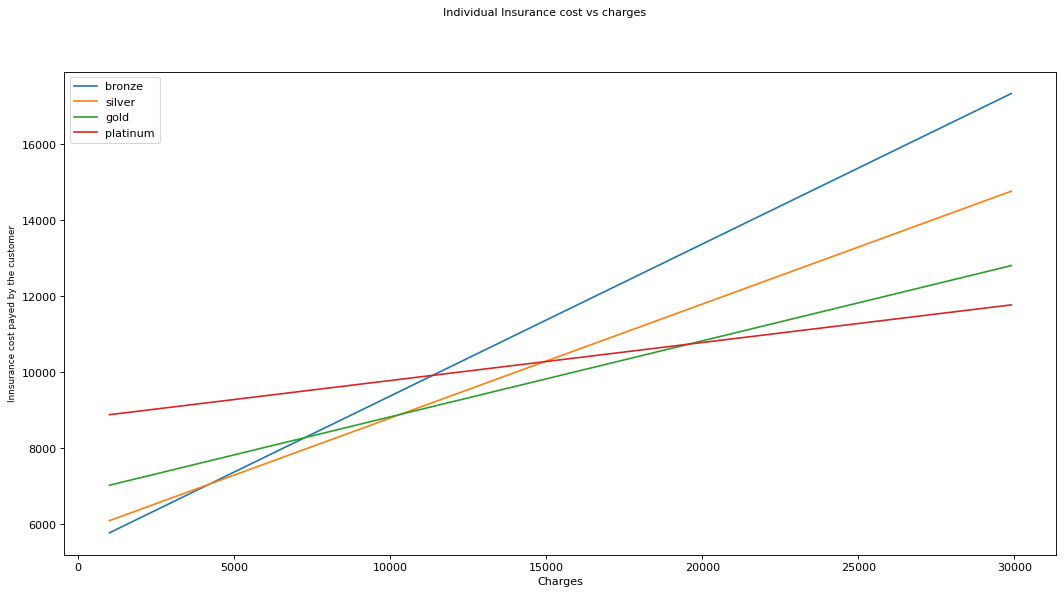

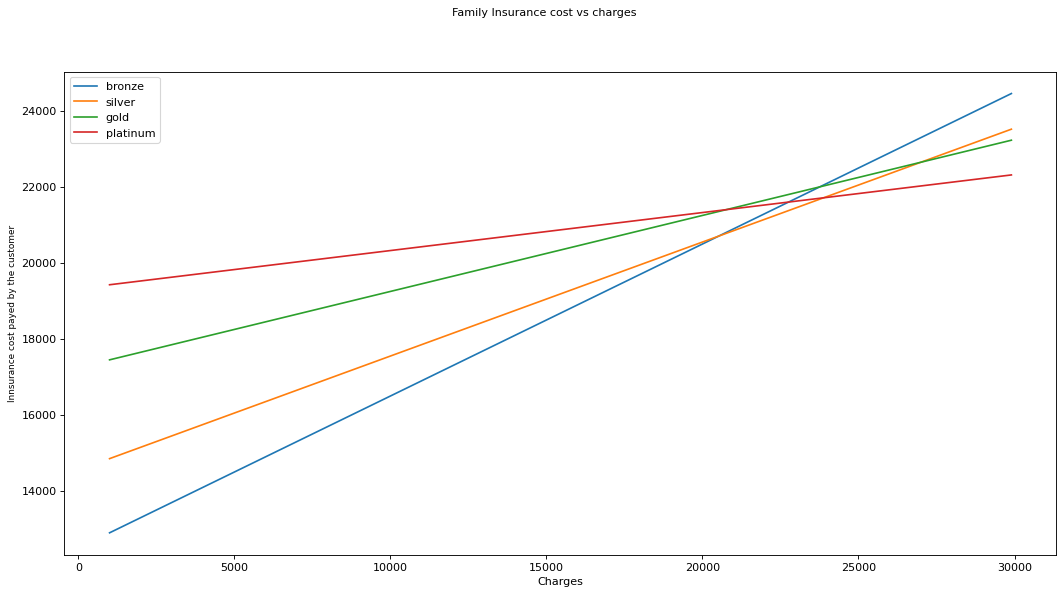

In [43]:
# plot the equations of 
figure(figsize=(16, 8), dpi=80)

ind_plans = {'bronze': [5376, 0.4], 'silver': [
    5796, 0.3], 'gold': [6828, 0.2], 'platinum': [8784, 0.1]}
family_plans = {'bronze': [12492, 0.4], 'silver': [
    14544, 0.3], 'gold': [17244, 0.2], 'platinum': [19320, 0.1]}

medical_cost_range = range(1000, 30000, 100)

bronze_cost = [ind_plans['bronze'][0]+x*ind_plans['bronze'][1]
               for x in medical_cost_range]
silver_cost = [ind_plans['silver'][0]+x*ind_plans['silver'][1]
               for x in medical_cost_range]
gold_cost = [ind_plans['gold'][0]+x*ind_plans['gold'][1]
             for x in medical_cost_range]
platinum_cost = [ind_plans['platinum'][0]+x*ind_plans['platinum'][1]
                 for x in medical_cost_range]

plt.plot(medical_cost_range, bronze_cost, label='bronze')
plt.plot(medical_cost_range, silver_cost, label='silver')
plt.plot(medical_cost_range, gold_cost, label='gold')
plt.plot(medical_cost_range, platinum_cost, label='platinum')
plt.legend()
plt.suptitle('Individual Insurance cost vs charges', fontsize=10)
plt.xlabel('Charges', fontsize=10)
plt.ylabel('Innsurance cost payed by the customer', fontsize=8)
plt.show()


figure(figsize=(16, 8), dpi=80)
bronze_cost = [family_plans['bronze'][0]+x*family_plans['bronze'][1]
               for x in medical_cost_range]
silver_cost = [family_plans['silver'][0]+x*family_plans['silver'][1]
               for x in medical_cost_range]
gold_cost = [family_plans['gold'][0]+x*family_plans['gold'][1]
             for x in medical_cost_range]
platinum_cost = [family_plans['platinum'][0]+x *
                 family_plans['platinum'][1] for x in medical_cost_range]

plt.plot(medical_cost_range, bronze_cost, label='bronze')
plt.plot(medical_cost_range, silver_cost, label='silver')
plt.plot(medical_cost_range, gold_cost, label='gold')
plt.plot(medical_cost_range, platinum_cost, label='platinum')
plt.legend()
plt.suptitle('Family Insurance cost vs charges', fontsize=10)
plt.xlabel('Charges', fontsize=10)
plt.ylabel('Innsurance cost payed by the customer', fontsize=8)
plt.show()

,123ageInt,AbcsexVarchar(20),"123bmiNumeric(8,4)",123childrenInt,010smokerBoolean,AbcregionVarchar(20),123chargesFloat,Abcsmoker_statusVarchar(11),Abcchildren_statusVarchar(12),AbcwsVarchar(11),Abccharges_catVarchar(14),Abcinsurance_planVarchar(8)
1,18,female,20.79,0,❌,southeast,1607.5101,none smoker,no children,Healthy,lower than 32k,bronze
2,18,female,21.66,0,✅,northeast,14283.4594,smoker,no children,Healthy,lower than 32k,gold
3,18,female,24.09,1,❌,southeast,2201.0971,none smoker,has children,Healthy,lower than 32k,bronze
4,18,female,25.08,0,❌,northeast,2196.4732,none smoker,no children,Overweight,lower than 32k,bronze
5,18,female,26.315,0,❌,northeast,2198.18985,none smoker,no children,Overweight,lower than 32k,bronze
6,18,female,26.73,0,❌,southeast,1615.7667,none smoker,no children,Overweight,lower than 32k,bronze
7,18,female,27.28,3,✅,southeast,18223.4512,smoker,has children,Overweight,lower than 32k,bronze
8,18,female,28.215,0,❌,northeast,2200.83085,none smoker,no children,Overweight,lower than 32k,bronze
9,18,female,29.165,0,❌,northeast,7323.734819,none smoker,no children,Overweight,lower than 32k,silver
10,18,female,30.115,0,❌,northeast,2203.47185,none smoker,no children,Obese,lower than 32k,bronze

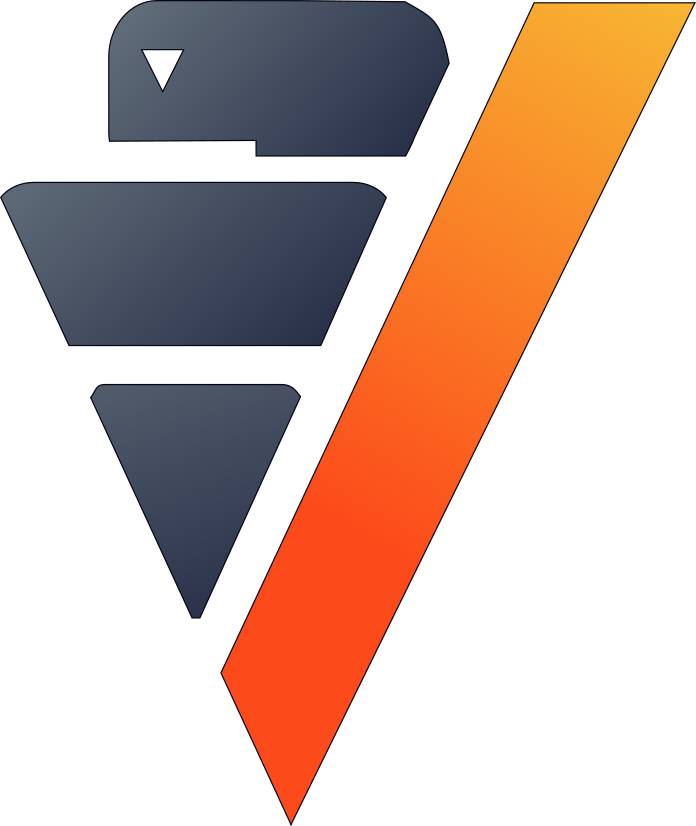

In [44]:
# add insurance_plan column reprenting the best insurance plan for every sample
insurance_data.eval(name = "insurance_plan", 
             expr = "CASE WHEN charges<=5000 AND children =0 THEN 'bronze' WHEN charges<=20000 AND children <>0 THEN 'bronze' WHEN charges<=10000 AND children =0 THEN 'silver' WHEN charges<=48000 AND children <>0 THEN 'silver' WHEN charges>20000 AND children =0 THEN 'platinum' WHEN charges>48000 AND children <>0 THEN 'platinum' ELSE 'gold' END")

In [45]:
# Add a new feature Weight Status
insurance_data.hchart(x="insurance_plan",
                      kind="bar",
                      height=250,
                      width=900)

The classes are not balanced, the `bronze` represented by __60%__ of the samples, `silver` by __18%__, `gold` by __13%__, and `platinum` by __9%__ 

In [46]:
# save our modified dataset to the database
# insurance_data.to_db("insurance.final_insurance_data_clas", relation_type = "table")
# split data to train and test sudsets
train_data, test_data = insurance_data.train_test_split(test_size=0.3,
                                                        random_state=1)

In [47]:
# over sample the training data to 70% for the minority classes
# train_data = train_data.balance(column = "insurance_plan", method = "over", x = 0.5)
# train_data.hchart(x="insurance_plan",
#                       kind="bar",
#                       height=250,
#                       width=900)


In [48]:
# save the subsets in database
# vp.drop("final_train_insurance_data_clas", relation_type="table")
# vp.drop("final_test_insurance_data_clas", relation_type="table")
# train_data.to_db("final_train_insurance_data_clas", relation_type="table")
# test_data.to_db("final_test_insurance_data_clas", relation_type="table")

In [49]:
# define the random forest model
rf_model = RandomForestClassifier(name="insurance.randf_model_insurance",
                                             n_estimators=25,
                                             max_features="auto",
                                             max_leaf_nodes=70,
                                             sample=1.0,
                                             max_depth=6,
                                             min_samples_leaf=2,
                                             min_info_gain=0.0,
                                             nbins=32)

predictors = ['sex', 'smoker_status', 'region', 'ws', 'age', 'children']
target = "insurance_plan"
# train the model
rf_model.fit(train_data,
                        predictors,
                        target)



call_string
SELECT rf_classifier('insurance.randf_model_insurance', '"insurance"."_verticapy_tmp_view_dbadmin_127340_8204399150_"', 'insurance_plan', '"sex", "smoker_status", "region", "ws", "age", "children"' USING PARAMETERS exclude_columns='', ntree=25, mtry=3, sampling_size=1, max_depth=6, max_breadth=70, min_leaf_size=2, min_info_gain=0, nbins=32);

details
  predictor  |     type      
-------------+---------------
     sex     |char or varchar
smoker_status|char or varchar
   region    |char or varchar
     ws      |char or varchar
     age     |      int      
  children   |      int      


Additional Info
       Name       |Value
------------------+-----
    tree_count    | 25  
rejected_row_count|  0  
accepted_row_count| 936 

,importance,sign
age,35.2,1
smoker_status,31.27,1
children,27.11,1
ws,4.64,1
region,1.27,1
sex,0.51,1

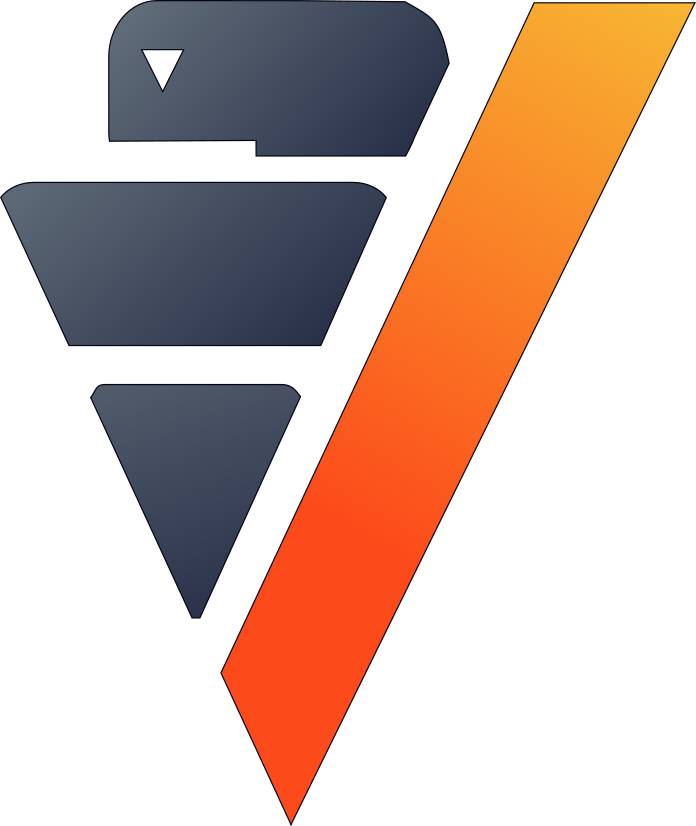

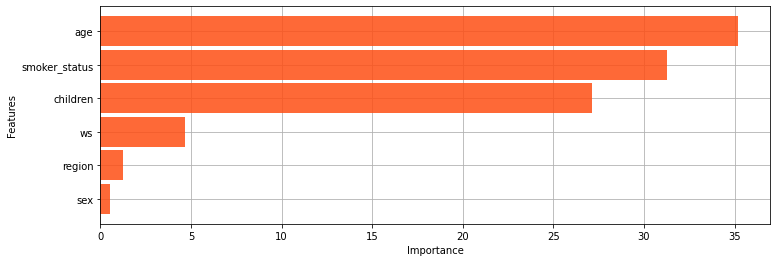

In [50]:
# feature importance for our random forest model
rf_model.features_importance()

The goal is to maximize the recall, for instance, maximize : (number of predicted plan/number of actual plan)


In [51]:
xgb_model = XGBoostClassifier(name="insurance.xgb_model_insurance",
                              max_ntree=20,
                              max_depth=6,
                              nbins=32,
                              split_proposal_method="global",
                              tol=0.001,
                              learning_rate=0.1,
                              min_split_loss=0.0,
                              weight_reg=0.0,
                              sample=1.0,
                              col_sample_by_tree=1.0,
                              col_sample_by_node=1.0,)

xgb_model.fit(train_data,
              predictors,
              target)




call_string
xgb_classifier('insurance.xgb_model_insurance', '"insurance"."_verticapy_tmp_view_dbadmin_127340_1019133551_"', '"insurance_plan"', '"sex", "smoker_status", "region", "ws", "age", "children"' USING PARAMETERS exclude_columns='', max_ntree=20, max_depth=6, learning_rate=0.1, min_split_loss=0, weight_reg=0, nbins=32, objective=crossentropy, sampling_size=1, col_sample_by_tree=1, col_sample_by_node=1)

details
  predictor  |     type      
-------------+---------------
     sex     |char or varchar
smoker_status|char or varchar
   region    |char or varchar
     ws      |char or varchar
     age     |      int      
  children   |      int      


initial_prediction
response_label| value  
--------------+--------
    bronze    | 0.00000
     gold     | 0.00000
   platinum   | 0.00000
    silver    | 0.00000


Additional Info
       Name       |Value
------------------+-----
    tree_count    | 20  
rejected_row_count|  0  
accepted_row_count| 936 

,bronze,gold,platinum,silver
auc,0.9851274956467814,0.9825788751714656,0.985356523818064,0.9622886866059812
prc_auc,0.9888267653090871,0.9444566969543361,0.9326921178896593,0.9159116405541514
accuracy,0.9455128205128205,0.9797008547008547,0.9337606837606838,0.9508547008547008
log_loss,0.070323027139897,0.0431608843280427,0.0399834668113408,0.0736698805185081
precision,0.9556737588652482,0.9212598425196851,0.5597014925373134,0.8757763975155279
recall,0.9539823008849557,0.9285714285714286,0.9615384615384616,0.844311377245509
f1_score,0.9548272807794509,0.924901185770751,0.7075471698113207,0.8597560975609756
mcc,0.886188977121592,0.9131752952500817,0.7045192169621991,0.8301796141863693
informedness,0.8865968561410205,0.9162257495590829,0.8927738927738929,0.8183035749048067
markedness,0.8857812857469685,0.9101349970314279,0.5559608441582609,0.8422280104187538

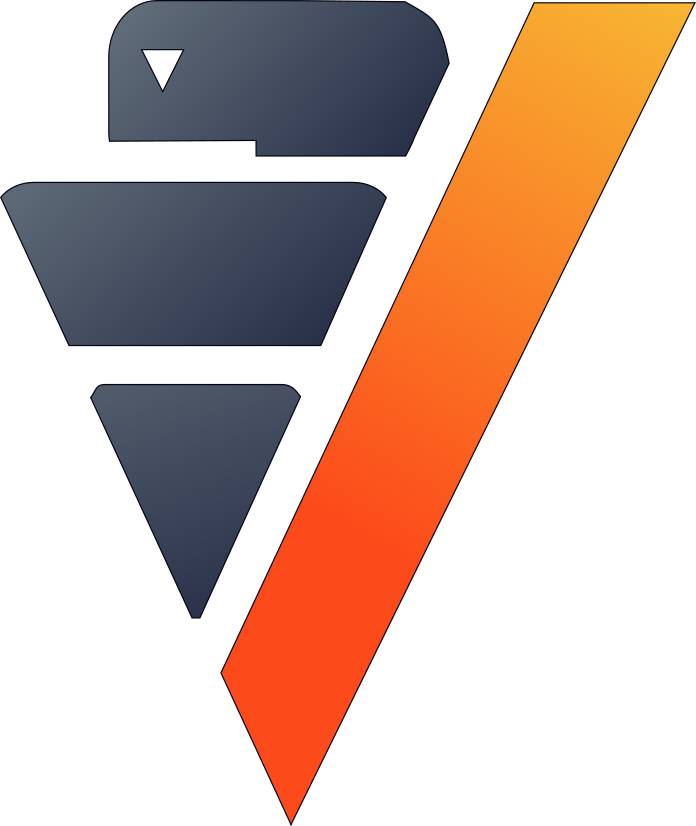

In [52]:
# classification report for Random Forest model
rf_model.report()

,bronze,gold,platinum,silver
auc,0.9802065691863656,0.9910444836370761,0.976689976689977,0.980657670354999
prc_auc,0.9844705884322421,0.9548680809684533,0.8995394332229996,0.932428328794115
accuracy,0.9540598290598291,0.9775641025641025,0.9423076923076923,0.9209401709401709
log_loss,0.103983683643558,0.0578541279598389,0.0558365346327456,0.0825759856485992
precision,0.9379194630872483,0.9007633587786259,0.603448275862069,0.7123287671232876
recall,0.9893805309734514,0.9365079365079365,0.8974358974358975,0.9341317365269461
f1_score,0.9629629629629629,0.9182879377431906,0.7216494845360825,0.8082901554404145
mcc,0.9048317033599499,0.9055208028151108,0.7077930645671852,0.7706992715272276
informedness,0.8896500727524272,0.920458553791887,0.8438228438228439,0.8522071591537341
markedness,0.9202724042637187,0.8908254705798682,0.5936921783010933,0.6969870655891175

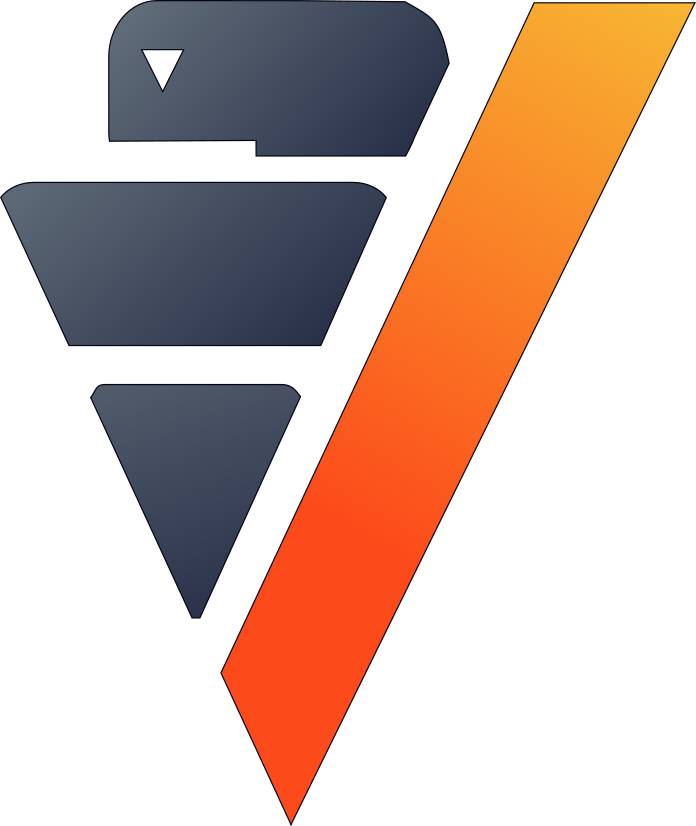

In [53]:
# classification report for XGBoost model
xgb_model.report()

In [54]:
def kappa_score(confusion_mat):
    
    # number of samples
    n_samples = confusion_mat.sum()
    # observed agreement
    observed_mat = confusion_mat/n_samples

    # probs of each class w.r.t truth
    actual_prob = confusion_mat.sum(axis=1)/n_samples
    # probs of each class w.r.t prediction
    pred_prob = confusion_mat.sum(axis=0)/n_samples
    # matrix prob by chance agreement
    prob_bychance = np.outer(actual_prob, pred_prob)


    N=confusion_mat.shape[0]
    # weights matrix (distance)
    weights_mat = np.zeros((N,N))
    for i in range(len(weights_mat)): 
        for j in range(len(weights_mat)):
            weights_mat[i][j] = 1 - float(((i-j)**2)/(N-1)**2)

    # prob of agreement 
    agreement_prob = np.multiply(observed_mat,weights_mat).sum()
    # prob of by chance agreement
    bychance_agreement_prob = np.multiply(prob_bychance,weights_mat).sum()
    # compute kappa score
    kappa_score = (agreement_prob - bychance_agreement_prob)/(1-bychance_agreement_prob)
    
    
    return kappa_score

In [68]:
def evaluation_report(model, test_data=test_data, prediction_label='prediction', target='insurance_plan'):
    
 
    # labels
    labels = ['bronze', 'silver', 'gold', 'platinum']
    n_labels = len(labels)
    # prediction
    model.predict(test_data,
                            X=predictors,
                            name=prediction_label)
    
    
    # confusion matrix
    confusion_mat = multilabel_confusion_matrix(target,
                            prediction_label,
                            test_data,
                            labels=labels).to_numpy()
    # drop the prediction column
    test_data.drop(columns=[prediction_label])
    # count number of samples
    n_samples = confusion_mat.sum()
    # innitialize variables
    accuracy_score = f1_macro = precision_macro = recall_macro = weighted_f1 = 0

    quadratic_kappa_score = kappa_score(confusion_mat)

    print ("{:<8} {:<15} {:<10} {:<10}".format('','Recall','Precision','F1-score'))
    
    for i, label in enumerate(labels):
        accuracy_score += confusion_mat[i,i]/n_samples
        recall_score = confusion_mat[i,i]/sum(confusion_mat[i,:])
        precision_score = confusion_mat[i,i]/sum(confusion_mat[:,i])
        f1_score = 2 *(precision_score*recall_score)/(precision_score+recall_score)
        
        f1_macro += f1_score/n_labels
        precision_macro += precision_score/n_labels
        recall_macro += recall_score/n_labels
        weighted_f1 += sum(confusion_mat[i])*f1_score/n_samples
        print ("{:<8} {:<15} {:<10} {:<10}".format(label, 
                                                   round(recall_score,3), 
                                                   round(precision_score,3), 
                                                   round(f1_score,3)))


    print ("\n{:<10} {:<15} {:<20} {:<25} {:<20} {:<20}".format('Accuracy',
                                                        'Marco-Recall',
                                                        'Marco-Precision',
                                                        'Macro-F1',
                                                        'Weighted-F1',
                                                        'Kappa Score (Q)'))

    print ("\n{:<10} {:<15} {:<20} {:<25} {:<20} {:<20}".format(round(accuracy_score,3),
                                                        round(recall_macro,3),
                                                        round(precision_macro,3),
                                                        round(f1_macro,3),
                                                        round(weighted_f1,3),
                                                        round(quadratic_kappa_score,3)))


In [69]:
print("Random Forest Model Results:\n")
evaluation_report(rf_model,test_data)

Random Forest Model Results:

         Recall          Precision  F1-score  
bronze   0.979           0.929      0.954     
silver   0.787           0.819      0.803     
gold     0.917           0.88       0.898     
platinum 0.658           0.962      0.781     

Accuracy   Marco-Recall    Marco-Precision      Macro-F1                  Weighted-F1          Kappa Score (Q)     

0.905      0.835           0.898                0.859                     0.902                0.901               


In [71]:
print("XGBoost Model Results:\n")
evaluation_report(xgb_model,test_data)

XGBoost Model Results:

         Recall          Precision  F1-score  
bronze   0.971           0.925      0.947     
silver   0.773           0.795      0.784     
gold     0.938           0.882      0.909     
platinum 0.658           1.0        0.794     

Accuracy   Marco-Recall    Marco-Precision      Macro-F1                  Weighted-F1          Kappa Score (Q)     

0.9        0.835           0.9                  0.858                     0.898                0.898               
